# scQUEST AML Tutorial

TODO: Describe

## Import needed packages 

In [1]:
import scQUEST as scq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import preprocessing
import torch
import warnings
import anndata
from pathlib import Path

warnings.filterwarnings('ignore')

## Step 1: Load and explore CyTOF dataset 
TODO

In [2]:
ad = scq.dataset.aml_annotated_celltypes()
ad

AnnData object with n_obs × n_vars = 96381 × 39
    obs: 'fcs_file', 'celltype', 'complexcelltype', 'patient', 'ncells'
    var: 'channel', 'marker', 'usedformanualannotation', 'usedforPhenoGraphclustering'
    uns: 'fcs_header'

In [3]:
ad.obs.head()

,fcs_file,celltype,complexcelltype,patient,ncells
0,2011-08-19-AML08-f.A_cct_subtracted_normalized...,NKcells,CD16- NK cells,H1,2602.0
1,2011-08-19-AML08-f.A_cct_subtracted_normalized...,NKcells,CD16- NK cells,H1,2602.0
2,2011-08-19-AML08-f.A_cct_subtracted_normalized...,NKcells,CD16- NK cells,H1,2602.0
3,2011-08-19-AML08-f.A_cct_subtracted_normalized...,NKcells,CD16- NK cells,H1,2602.0
4,2011-08-19-AML08-f.A_cct_subtracted_normalized...,NKcells,CD16- NK cells,H1,2602.0


In [4]:
print('Number of unique files: ' + str(len(ad.obs['fcs_file'].unique())))
print('Number of unique patients: ' + str(len(ad.obs['patient'].unique())))

Number of unique files: 14
Number of unique patients: 2


Pre-process the whole dataset and censore outliers

In [5]:
# censor data to the 99.5% percentil
X = ad.X.copy()

quantiles = np.quantile(X, q=.995, axis=0)
for i, thres in zip(range(X.shape[1]), quantiles):
    X[X[:, i] > thres, i] = thres

# arcsinh-transform using a cofactor of 5
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)

# add transformed data to a separate layer in the annData object
ad.layers['arcsinh'] = X

## Step 2: Cell type identification
TODO

TODO[Johanna]: Describe how we selected the cells in the ad dataset

The single-cell data have been previously clustered in XX clusters (cluster id found in `obs['complexcelltype']`), and the clusters have been annotated by `celltype` and `celltype_class` included in `.obs`:

In [6]:
print('Number of unique compelex cell types: ' + str(len(ad.obs['complexcelltype'].unique())))
print('Number of unique cell types: ' + str(len(ad.obs['celltype'].unique())))

Number of unique compelex cell types: 7
Number of unique cell types: 6


In [7]:
print('Number of cells per cell type:\n' + str(ad.obs['celltype'].value_counts()))

Number of cells per cell type:
CD4Tcells    26366
Monocytes    21099
CD8Tcells    20108
Bcells       16520
NKcells       6153
PreBcells     6135
Name: celltype, dtype: int64


### Prepare dataset for classification
Let's prepare the dataset for classification by first selecting a list of markers that we will use for training the classifier. 

In [8]:
# define the markers used in the classifier
ad_anno = ad[:, ad.var.usedforPhenoGraphclustering == 'yes']

In [9]:
# standardise
scaler = StandardScaler()
X = scaler.fit_transform(ad_anno.layers['arcsinh'])
ad_anno.layers['arcsinh_norm'] = X

Before we train the classifier, let's visualize the data distribution per class. 

In [10]:
df = pd.DataFrame(data=ad_anno.layers['arcsinh_norm'], columns=ad_anno.var.marker)
df['celltype'] = ad.obs.celltype.values
df = df.groupby('celltype').sample(n=1000)
df = df.melt(id_vars='celltype')

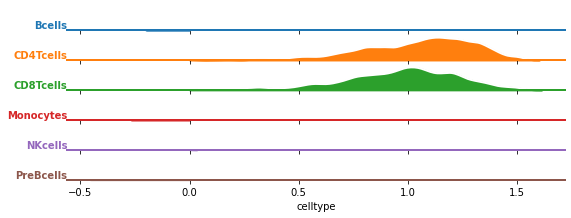

In [11]:
marker = 'CD3'
g = sns.FacetGrid(df[df.marker == marker], row="celltype", hue="celltype", aspect=15, height=.5)
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False, clip=(0, df.value.max()),
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5, clip=(0, df.value.max()))
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="right", va="center", transform=ax.transAxes)


g.map(label, "celltype")

# prevent the subplots from overlap
g.figure.subplots_adjust(hspace=+0.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

In [12]:
celltypes = ('Monocytes', 'NKcells')
mask = ad_anno.obs.celltype.isin(celltypes)
df_plot = pd.DataFrame(data=ad_anno[mask, :].layers['arcsinh'], columns=ad_anno.var.marker)
df_plot['celltype'] = ad_anno.obs.celltype.values[mask].astype(str)

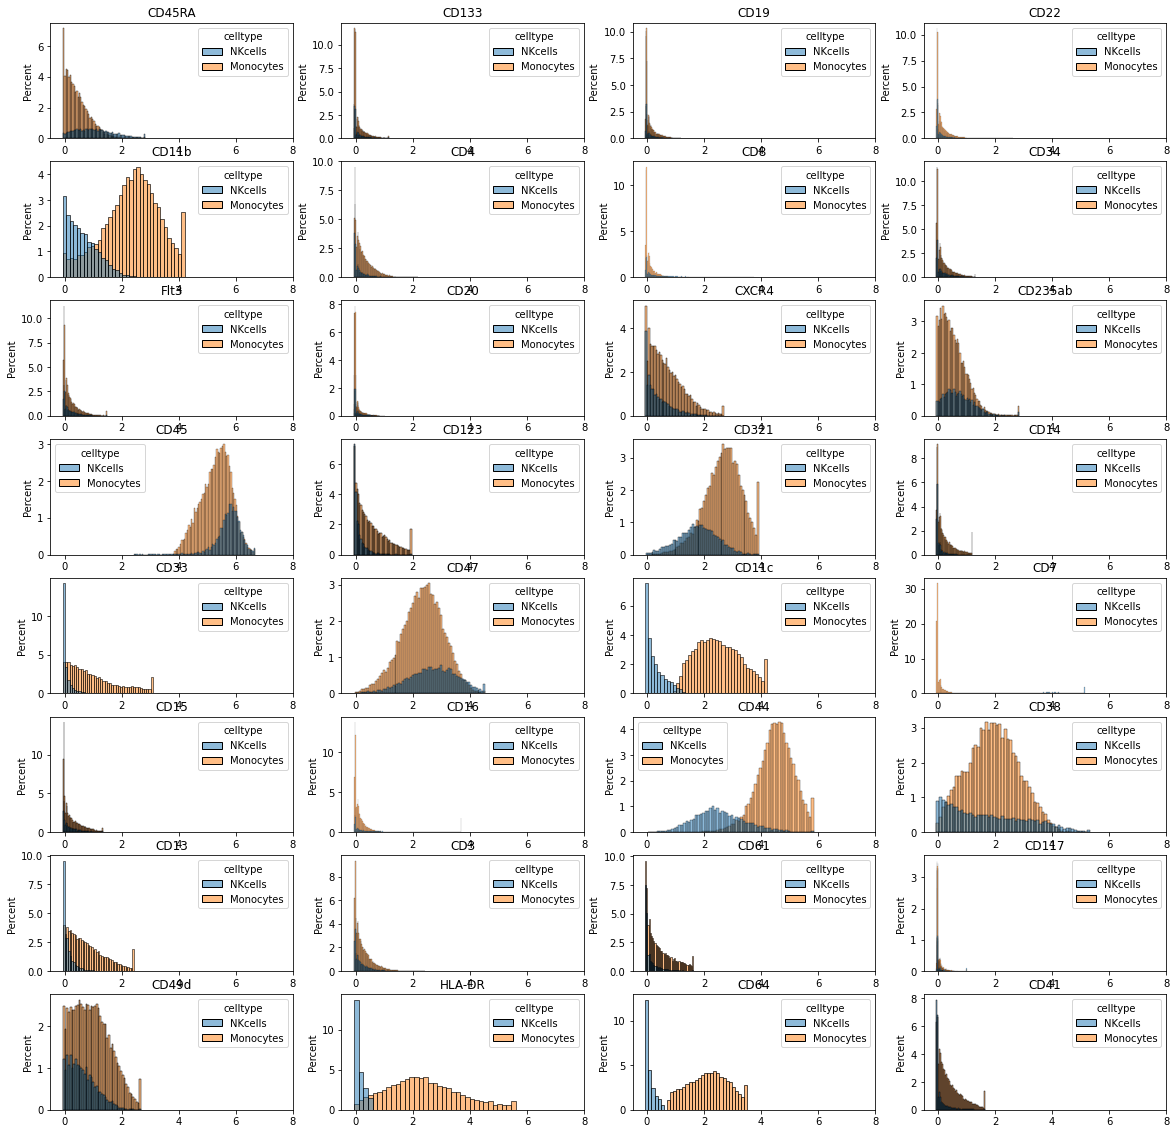

In [13]:
fig = plt.figure(figsize=(20, 20))
for m in range(0, df_plot.shape[1] - 1):
    plt.subplot(8, 4, m + 1)
    sns.histplot(data=df_plot, x=df_plot.columns[m], hue="celltype", stat='percent')
    plt.title(df_plot.columns[m])
    plt.xlim([-0.5, 8])
    plt.xlabel('')

#plt.savefig('marker_hist_annotated.pdf', dpi=300)
plt.show()

In [14]:
import umap as umap

df = pd.DataFrame(ad_anno.layers['arcsinh'], index=ad_anno.obs.celltype, columns=ad_anno.var.marker)
df = df.groupby('celltype').sample(5000)
df = df.sample(frac=1)

In [15]:
Y1 = umap.UMAP(n_neighbors=50, min_dist=0.5, metric='euclidean').fit_transform(df)
Y1 = pd.DataFrame(Y1, index=df.index, columns=['dim' + str(i) for i in range(Y1.shape[1])])

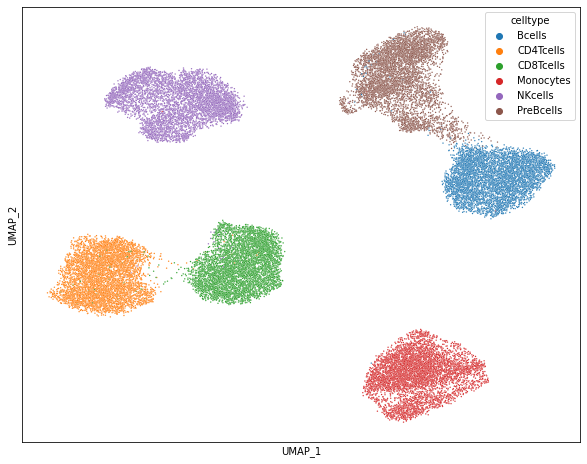

In [16]:
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x='dim0', y='dim1', hue='celltype', data=Y1, s=2)

plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.savefig('umap_celltype.png', dpi=300)
plt.show()

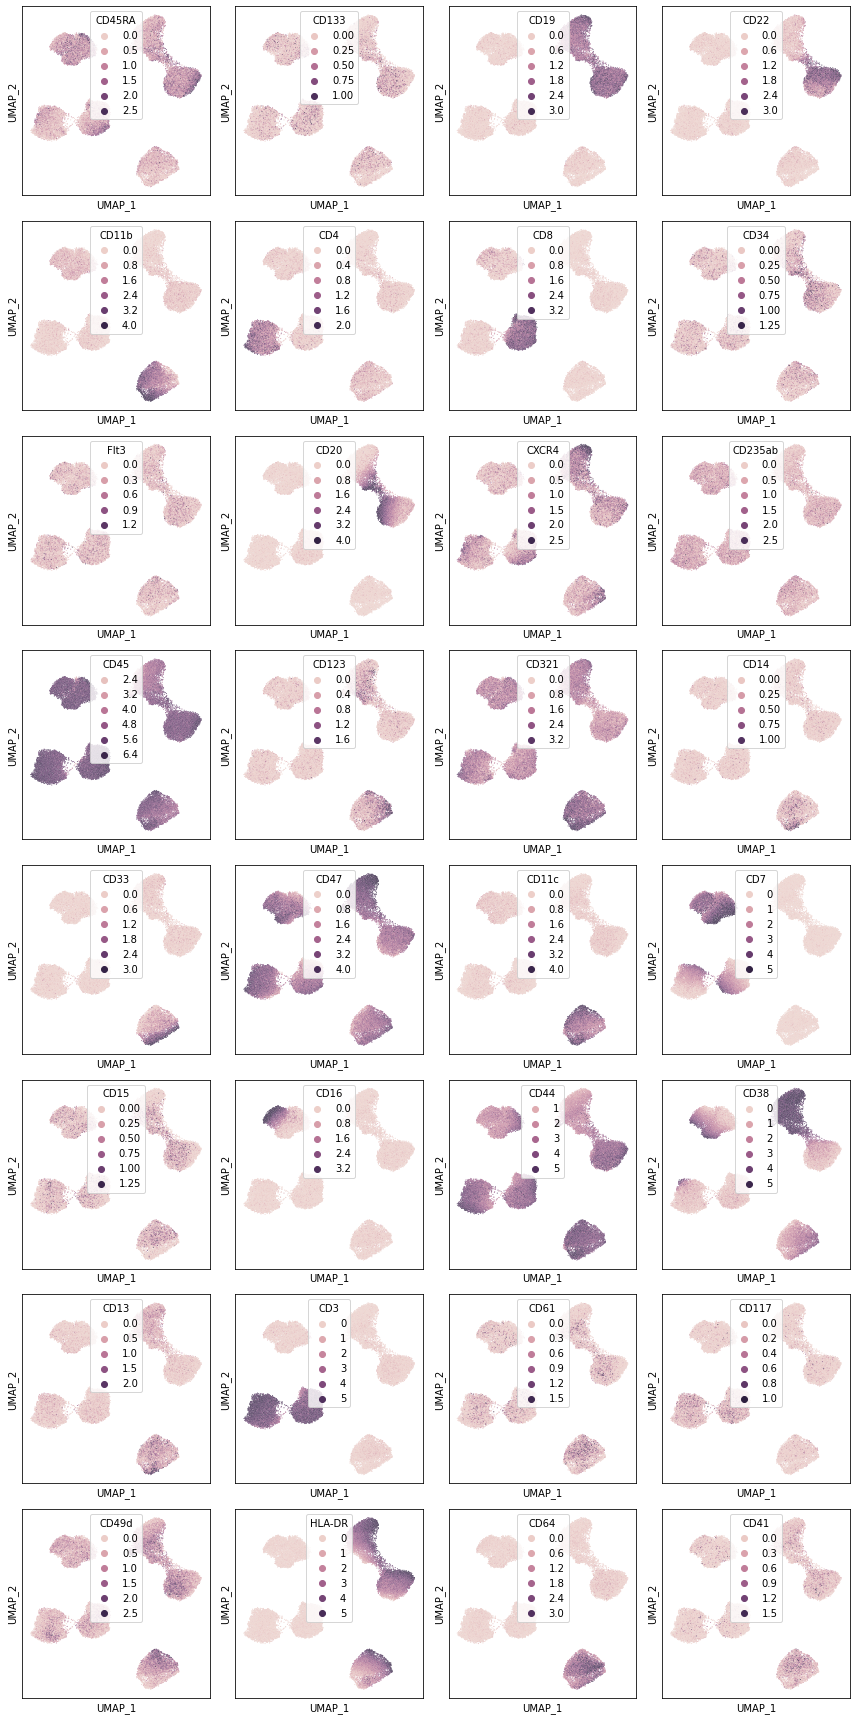

In [17]:
fig, axs = plt.subplots(8, 4, figsize=(4 * 3, 8 * 3))
for i, ax in zip(df.columns, axs.flat):
    _ = sns.scatterplot(x='dim0', y='dim1', hue=df[i], data=Y1, s=1, ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP_1')
    ax.set_ylabel('UMAP_2')

fig.tight_layout()
fig.savefig('umap_markers.png', dpi=300)
plt.show()

### Train the neural network classifier
We will next train a simple neural network classifier using the annotated data. We first initialize the model by defining the dimensions of the input layer equal to the number of markers in the training data. By default, the model architecture consists of 2 hidden layer of 16 and 8 neurons, (with a ReLU activation function) and one output layer of one neuron. The dataset is split into training (50%), validation (25%), and test (25%) sets in a stratified fashion to preserve cell type proportions. The classifier is trained using the scaled conjugate gradient method, and its performance is evaluated using a standard weighted cross-entropy loss function (as we saw in Step 2, the celltype distribution is very unbalanced). We also use an early stopping criterion by terminating training when the model's performance fails to improve for 10 consecutive  runs. For reproducibility, you can also optionally set a `seed`. 

In [18]:
ad_anno.obs['celltype_id'] = ad_anno.obs.groupby('celltype').ngroup()
n_classes = ad_anno.obs.celltype.nunique()
n_features = ad_anno.X.shape[1]
print(f'n_classes: {n_classes}')
print(f'n_features: {n_features}')

n_classes: 6
n_features: 32


In [19]:
from scQUEST.classifier import DefaultCLF, ClfLitModule
import torchmetrics
import torch
from torch import nn

model = DefaultCLF(n_in=n_features, n_out=n_classes, hidden=(16, 8))
model

DefaultCLF(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=6, bias=True)
  )
)

In [20]:
from torch import nn

counts = np.bincount(ad_anno.obs.celltype_id)
weight = 1 / counts
weight = weight / weight.sum()
weight = torch.tensor(weight).float()

loss = nn.CrossEntropyLoss(weight=weight)

In [21]:
mapping = ad_anno.obs[['celltype', 'celltype_id']].set_index('celltype_id').squeeze().to_dict()
df = pd.DataFrame({'counts': counts, 'weight': weight, 'celltype_id': range(len(counts))})
df['celltype'] = df.celltype_id.map(mapping)
df

,counts,weight,celltype_id,celltype
0,16520,0.116161,0,Bcells
1,26366,0.072783,1,CD4Tcells
2,20108,0.095434,2,CD8Tcells
3,21099,0.090951,3,Monocytes
4,6153,0.311878,4,NKcells
5,6135,0.312793,5,PreBcells


In [22]:
# define early stopping criterion
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-3, patience=10)

In [23]:
# initialize model and train classifier
clf = scq.Classifier(model=model, loss_fn=loss, seed=1)
clf.fit(ad_anno, layer='arcsinh', target='celltype_id', callbacks=[es], max_epochs=20, seed=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | DefaultCLF       | 718   
1 | loss             | CrossEntropyLoss | 0     
2 | metric_accuracy  | Accuracy         | 0     
3 | metric_f1score   | F1Score          | 0     
4 | metric_precision | Precision        | 0     
5 | metric_recall    | Recall           | 0     
------------------------------------------------------
718       Trainable params
0         Non-trainable params
718       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.004620830994099379
  test_metric_accuracy      0.9989625215530396
   test_metric_f1score      0.9989625215530396
  test_metric_precision     0.9989625215530396
   test_metric_recall       0.9989625215530396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


By observing the results, we see that the model achieves a XXX% accuracy and XXX% precision in the test set. Let's explore the model's performance in more detail by plotting the loss, the confusion matrix and the ROC curve:

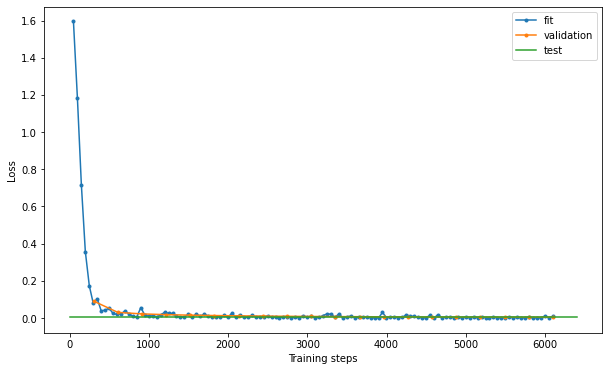

In [24]:
# examine model performance
hist = clf.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()
#plt.savefig('loss.pdf', dpi=300)


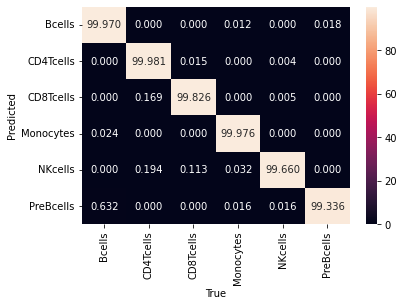

In [25]:
# %% confusion matrix
dl = clf.datamodule.test_dataloader()
data = dl.dataset.dataset.data
y = dl.dataset.dataset.targets
yhat = clf.model(data)

mapping = ad_anno.obs[['celltype', 'celltype_id']].set_index('celltype_id').squeeze().to_dict()
m = confusion_matrix(y, yhat, normalize='pred')
m = pd.DataFrame(m)
m.index = m.index.map(mapping)
m.columns = m.columns.map(mapping)
m.index.name = 'True'
m.columns.name = 'Predicted'
sns.heatmap(m.T * 100, annot=True, fmt='.3f');
#plt.savefig('confusion.pdf', dpi=300)

plt.show()

In [26]:
del ad_anno
del ad

## Step 3: Phenotypic abnormality

### Prepare dataset
TODO

In [27]:
ad = scq.dataset.aml_and_healthy()

In [28]:
ad.obs.head()

,fcs_file,patient,tissue,ncells
0,H1_NoDrug_Basal1_PhenoGraph.fcs,H1,healthy,15394.0
1,H1_NoDrug_Basal1_PhenoGraph.fcs,H1,healthy,15394.0
2,H1_NoDrug_Basal1_PhenoGraph.fcs,H1,healthy,15394.0
3,H1_NoDrug_Basal1_PhenoGraph.fcs,H1,healthy,15394.0
4,H1_NoDrug_Basal1_PhenoGraph.fcs,H1,healthy,15394.0


Pre-process the whole dataset and censore outliers

In [29]:
# censor data to the 99.5% percentil
X = ad.X.copy()

quantiles = np.quantile(X, q=.995, axis=0)
for i, thres in zip(range(X.shape[1]), quantiles):
    X[X[:, i] > thres, i] = thres

# arcsinh-transform using a cofactor of 5
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)

# add transformed data to a separate layer in the annData object
ad.layers['arcsinh'] = X

Next, subset the whole dataset to only include cells from the selected healty patients, and preprocess the data as before:

In [30]:
ad_train = ad[ad.obs.tissue == 'healthy', ad.var.usedforPhenoGraphclustering == 'yes']

In [31]:
n_features = ad_train.X.shape[1]
print(f'n_cells: {len(ad_train)}')
print(f'n_features: {n_features}')

n_cells: 183414
n_features: 30


In [32]:
# standardise
scaler = MinMaxScaler()
X = scaler.fit_transform(ad_train.layers['arcsinh'])
ad_train.layers['arcsinh_norm'] = X

In [33]:
assert np.isclose(ad_train.layers['arcsinh_norm'].max(), 1)
assert np.isclose(ad_train.layers['arcsinh_norm'].min(), 0)

### Train the abnormality Autoencoder

In [34]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-3, patience=10)

In [35]:
from scQUEST.abnormality import DefaultAE

model = DefaultAE(n_in=n_features, hidden=(16, 8, 4, 8, 16))
model

DefaultAE(
  (activation): ReLU()
  (activation_last): Sigmoid()
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=30, bias=True)
  )
)

In [36]:
# Initialize and fit the model
Abn = scq.Abnormality(model=model)
Abn.fit(ad_train, layer='arcsinh_norm', callbacks=[es], max_epochs=20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 1.4 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss              0.013673492707312107
test_metric_meansquarederror    0.013673494569957256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


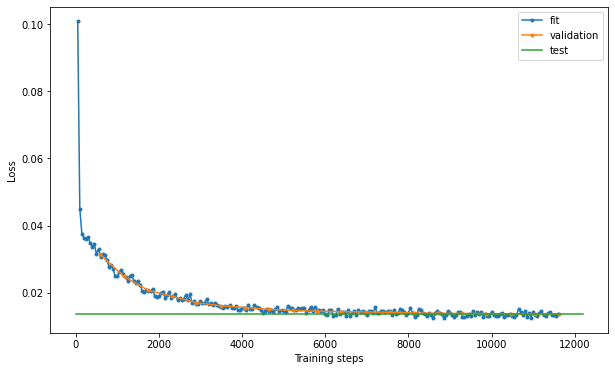

In [37]:
# examine model performance
hist = Abn.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()
#plt.savefig('loss.pdf', dpi=300)


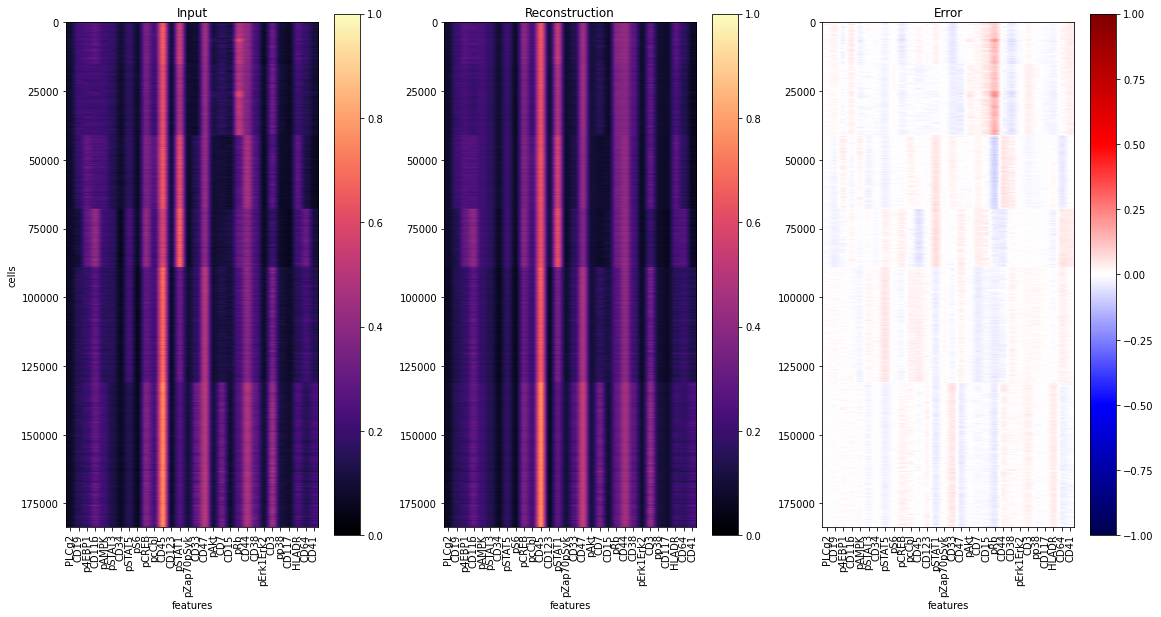

In [38]:
# estimate reconstruction error on the training data
Abn.predict(ad_train, layer='arcsinh_norm')
mse_train = (ad_train.layers['abnormality'] ** 2).mean(axis=1)
ad_train.obs['abnormality'] = mse_train

y = ad_train.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_train.layers['abnormality']

markers = ad_train.var['marker'].values
fig, axs = plt.subplots(1, 3, figsize=(16 * 1.2, 8 * 1.2))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    ax.set_aspect(dat.shape[1] * 2 / dat.shape[0])
    ax.set_xticks(range(len(markers)), labels=markers, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
fig.show()

In [39]:
del ad_train

### Reconstruct all cells
Now let's use the model to reconstruct all cells and compute the mean squared error of the reconstruction: 

In [40]:
# %% pre-process for Abnormality prediction
ad_pred = ad[:, ad.var.usedforPhenoGraphclustering == 'yes']
X = scaler.transform(ad_pred.layers['arcsinh'])
ad_pred.layers['arcsinh_norm'] = X

In [41]:
# estimate reconstruction error
Abn.predict(ad_pred, layer='arcsinh_norm')
mse = (ad_pred.layers['abnormality'] ** 2).mean(axis=1)
ad_pred.obs['abnormality'] = mse

To evaluate the results, let's reconstruct all single-cells and visualize the prediction residuals:

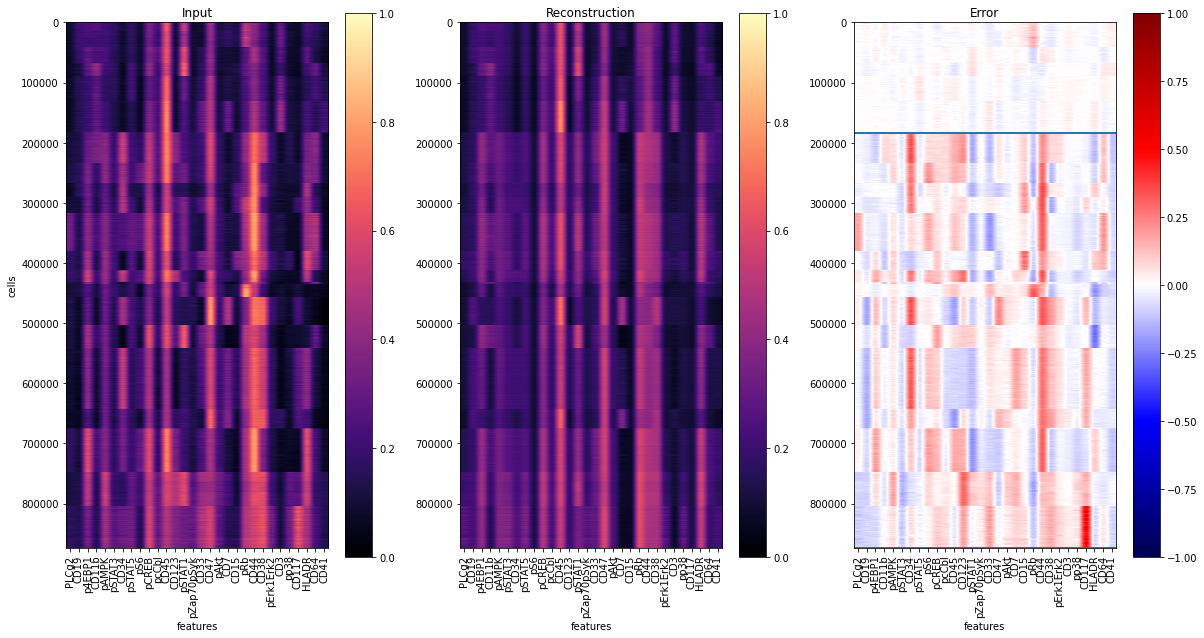

In [42]:
y = ad_pred.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_pred.layers['abnormality']
y1 = ad_pred.obs[ad_pred.obs['tissue'] == 'healthy'].shape[0]
y2 = ad_pred.obs[ad_pred.obs['tissue'] == 'AML'].shape[0]

markers = ad_pred.var['marker'].values
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    plt.hlines(y1, -0.5, len(markers) - 0.5)
    plt.hlines(y1 + y2, -0.5, len(markers) - 0.5)
    ax.set_aspect(dat.shape[1] * 2 / dat.shape[0])
    ax.set_xticks(range(len(markers)), labels=markers, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
#plt.savefig('reconstruction.pdf', dpi=300)
fig.show()

Now let's visualize the abnormality for different clinical data: 

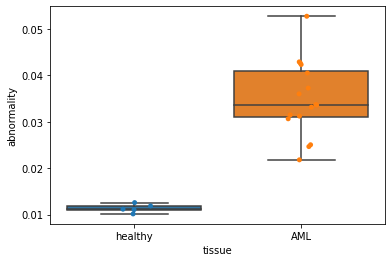

In [43]:
clinical_data = 'tissue'
order = ['healthy', 'AML']

fig, ax = plt.subplots()
dat = ad_pred.obs.groupby([clinical_data, 'patient']).abnormality.agg(
    np.median).dropna().reset_index()
sns.boxplot(data=dat, x=clinical_data, y='abnormality', order=order, whis=[0, 100], ax=ax)
sns.stripplot(data=dat, x=clinical_data, y='abnormality', order=order, ax=ax)
plt.savefig('abnormality_boxplots.pdf', dpi=300)

## Tumor individuality

For computing the individuality let's start by preparing the dataset. Here, because the k-nn graph construction is computationally intensive, we will randomly select a subset of cells from each sample. 

In [44]:
# preprocessing
ad.obs['sample_id'] = ad.obs.groupby(['tissue', 'patient']).ngroup()

# sub-sampling
tmp = ad.obs.groupby(['sample_id']).indices
n_cells = 200
indices = []
for key, item in tmp.items():
    size = min(len(item), n_cells)
    idx = np.random.choice(range(len(item)), size, replace=False)
    indices.extend(item[idx])
indices = np.array(indices)
ad = ad[indices]

Let us initialize the individuality model and use it to predict the scores:

In [45]:
Indiv = scq.Individuality()
Indiv.predict(ad, ad.obs.sample_id, layer='arcsinh')

The observation-level scores (one vector per single cell, indicating it's similarity to all other samples) are saved in the `.obsm` attribute of the AnnData object, as a matrix of size `n_cells x n_samples`:

In [46]:
ad.obsm['individuality']

matrix([[0.6 , 0.33, 0.06, ..., 0.  , 0.01, 0.  ],
        [0.71, 0.21, 0.01, ..., 0.  , 0.  , 0.  ],
        [0.68, 0.2 , 0.02, ..., 0.  , 0.  , 0.  ],
        ...,
        [0.02, 0.  , 0.1 , ..., 0.04, 0.1 , 0.19],
        [0.  , 0.  , 0.03, ..., 0.  , 0.06, 0.01],
        [0.  , 0.  , 0.02, ..., 0.03, 0.26, 0.07]])

The aggregated sample-level scores (one vector per sample, indicating a sample's similarity to all other samples) are saved in the .uns attribute of the AnnData object, as a matrix of size `n_samples x n_samples`:

In [47]:
# access sample-level aggregated individuality
ad.uns['individuality_agg'].head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.57120,0.25465,0.02225,0.00000,0.00000,0.00480,0.00135,0.00005,0.00515,0.00510,...,0.00025,0.00840,0.05555,0.0074,0.00545,0.00010,0.00335,0.0004,0.00555,0.01335
1,0.35075,0.41760,0.02940,0.00000,0.00000,0.00745,0.00130,0.00010,0.01135,0.00460,...,0.00045,0.00950,0.08650,0.0086,0.00475,0.00020,0.00270,0.0002,0.00610,0.01780
2,0.01800,0.01175,0.44450,0.00000,0.00000,0.09315,0.00010,0.00005,0.03900,0.02735,...,0.06375,0.05515,0.05820,0.0002,0.01675,0.00355,0.01290,0.0016,0.02470,0.03915
3,0.00000,0.00000,0.00015,0.63470,0.32685,0.00975,0.00000,0.00135,0.00005,0.00110,...,0.00205,0.00065,0.00000,0.0000,0.00035,0.01115,0.00050,0.0000,0.00590,0.00545
4,0.00000,0.00000,0.00025,0.26705,0.68345,0.01020,0.00005,0.00155,0.00005,0.00120,...,0.00140,0.00020,0.00000,0.0000,0.00030,0.01385,0.00095,0.0004,0.00950,0.00960


To assess a sample's uniqueness withn the cohort, we will use the diagonal of that matrix:

In [48]:
dat = ad.uns['individuality_agg'].copy()
dat = pd.DataFrame(np.diag(dat), index=dat.index, columns=['individuality'])

Now let's assess how individuality scores are related to a patient's clinical data:

<AxesSubplot:xlabel='tissue', ylabel='individuality'>

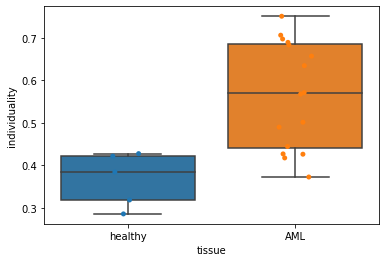

In [49]:
res = ad.obs[['tissue', 'patient', 'sample_id']]
res = res[~res.duplicated()].set_index('sample_id')
dat = pd.concat((dat, res), axis=1)

clinical_data = 'tissue'
order = ['healthy', 'AML']

fig, ax = plt.subplots()
sns.boxplot(data=dat, x=clinical_data, y='individuality', order=order, whis=[0, 100], ax=ax)
sns.stripplot(data=dat, x=clinical_data, y='individuality', order=order, ax=ax)
#plt.savefig('individuality_boxplots.pdf', dpi=300)